# Implementation of paper - "Online crowdsourcing: rating annotators and obtaining cost-effective labels" (https://core.ac.uk/download/pdf/33111700.pdf)

## Import all libraries

In [1]:
import random, yaml
import numpy as np
import scipy as sp
import pandas as pd
import xlsxwriter
import xlrd

import pymc3 as pm

%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

from scipy.stats import bernoulli, uniform

/home/pallavi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Either use HIT Spam Crowdflower dataset or BlueBirds dataset. Accordingly execute either this block or next one, but not both.

### HIT Spam Crowdflower dataset (Dataset # 1)

1. Retrieve gold data, worker label data
2. Set prior on label from categories-with-priors.txt - No (0.6), Yes (0.4)
3. Remove duplicates from labels.txt
4. Initialize p(aj)
5. Initialize zi prior - p(zi)

In [2]:
# Create an empty dataframe
gold_data = pd.read_csv('/home/pallavi/Documents/phd/Paper implementation/crowdsourcing/data/HITspam-UsingCrowdflower/gold.txt', sep = "\t", header = None)
gold_data.columns = ["Sample", "Label"]
print(gold_data)

worker_label_data = pd.read_csv('/home/pallavi/Documents/phd/Paper implementation/crowdsourcing/data/HITspam-UsingCrowdflower/labels.txt', sep = "\t", header = None)
worker_label_data.columns = ["WorkerId", "Sample", "Label"]
worker_label_data

                                                Sample Label
0    http://www.mturk-tracker.com/hit/03a26f4ac8b35...    No
1    http://www.mturk-tracker.com/hit/05db9d67a043b...    No
2    http://www.mturk-tracker.com/hit/0880a7a9c8b1c...    No
3    http://www.mturk-tracker.com/hit/10AC01KUHNTNB...    No
4    http://www.mturk-tracker.com/hit/10NEXIBULHEST...    No
5    http://www.mturk-tracker.com/hit/10NEXJ50388ZT...    No
6    http://www.mturk-tracker.com/hit/11WH0Y8R2W249...    No
7    http://www.mturk-tracker.com/hit/11WHAPTQS59Q1...    No
8    http://www.mturk-tracker.com/hit/11WHAQ0TH4PRS...    No
9    http://www.mturk-tracker.com/hit/11WHAR7Z3KURR...    No
10   http://www.mturk-tracker.com/hit/130LIK88X8MUR...    No
11   http://www.mturk-tracker.com/hit/130LIKCET06TC...    No
12   http://www.mturk-tracker.com/hit/130LSCBY78UIQ...    No
13   http://www.mturk-tracker.com/hit/130LSCJWK07WC...    No
14   http://www.mturk-tracker.com/hit/130LSCU5SOO11...    No
15   http://www.mturk-tr

,WorkerId,Sample,Label
0,184974,http://www.mturk-tracker.com/hit/0052c22a98bbd...,No
1,460747,http://www.mturk-tracker.com/hit/0052c22a98bbd...,No
2,485904,http://www.mturk-tracker.com/hit/0052c22a98bbd...,No
3,575578,http://www.mturk-tracker.com/hit/0052c22a98bbd...,No
4,184974,http://www.mturk-tracker.com/hit/0052c22a98bbd...,No
5,188094,http://www.mturk-tracker.com/hit/0052c22a98bbd...,No
6,430781,http://www.mturk-tracker.com/hit/0052c22a98bbd...,No
7,460747,http://www.mturk-tracker.com/hit/0052c22a98bbd...,No
8,575578,http://www.mturk-tracker.com/hit/005e9abf95ecf...,No
9,42299,http://www.mturk-tracker.com/hit/005e9abf95ecf...,No


### Bluebirds

1. Retrieve gold data, worker label data
2. Set prior on label from categories-with-priors.txt - No (0.5), Yes (0.5)
3. Remove duplicates from labels.txt
4. Initialize p(aj)
5. Initialize zi prior - p(zi)

In [2]:
gold_data = pd.DataFrame()
gtLabels = yaml.load(open('./../data/bluebirds/gt.yaml'))
imgIds = [id for id in gtLabels.keys()]
gt = [gtLabels[id] for id in gtLabels.keys()]
data = pd.DataFrame({"Sample": imgIds, "Label": gt})
gold_data = gold_data.append(data)
print(gold_data)

imgIds = []
labels = []
workerIds = []
worker_label_data = pd.DataFrame()
data = yaml.load(open('./../data/bluebirds/labels.yaml'))
wkrIds = [id for id in data.keys()]
for wkrId in wkrIds:
    for (imgId, label) in data[wkrId].items():
        workerIds.append(wkrId)
        imgIds.append(imgId)
        labels.append(label)
worker_label_data = pd.DataFrame({"WorkerId": workerIds, "Sample": imgIds, "Label": labels})
worker_label_data

     Label  Sample
0     True   11573
1     True   11574
2     True   11575
3     True   11577
4     True   11578
5     True   11579
6     True   11580
7     True   11583
8     True   11585
9     True   11588
10    True   11594
11    True   11596
12    True   11600
13    True   11601
14    True   11602
15    True   11604
16    True   11612
17    True   11615
18    True   11617
19    True   11618
20    True   11619
21    True   11626
22    True   11628
23    True   11629
24    True   11630
25    True   11637
26    True   11641
27    True   11642
28    True   11644
29    True   11645
..     ...     ...
78   False   36680
79   False   36683
80   False   36691
81   False   36693
82   False   36696
83   False   36697
84   False   36701
85   False   36931
86   False   36932
87   False   36933
88   False   36934
89   False   36935
90   False   36936
91   False   36937
92   False   36939
93   False   36940
94   False   36941
95   False   36942
96   False   36943
97   False   36947
98   False  

,Label,Sample,WorkerId
0,True,11573,39
1,True,11574,39
2,True,11575,39
3,False,11577,39
4,True,11578,39
5,True,11579,39
6,True,11580,39
7,True,11583,39
8,True,11585,39
9,True,11588,39


## Next 2 blocks removes  entries from worker table which do not have any ground truth information available. (Ground truth information is used only to calculate accuracy. It is not used in the main algorithm)

In [3]:
worker_label_data = worker_label_data.drop_duplicates()
criteria = worker_label_data['Sample'].isin(gold_data['Sample'])
worker_label_data[criteria]

,WorkerId,Sample,Label
150,460747,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
151,188054,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
152,291622,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
153,250203,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
154,930530,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
156,1120268,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
157,931819,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
158,184974,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
159,485904,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
160,430781,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No


In [4]:
worker_label_data = worker_label_data[criteria]
worker_label_data.reset_index(drop=True, inplace=True)
worker_label_data

,WorkerId,Sample,Label
0,460747,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
1,188054,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
2,291622,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
3,250203,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
4,930530,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
5,1120268,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
6,931819,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
7,184974,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
8,485904,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No
9,430781,http://www.mturk-tracker.com/hit/03a26f4ac8b35...,No


## Initialize annotator reliability prior from Beta mixture distribution by executing next 2 blocks.

/home/pallavi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


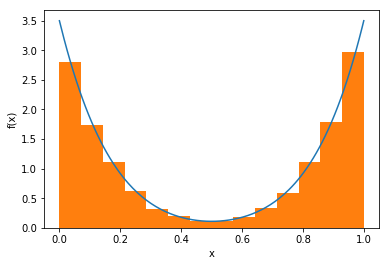

In [5]:
# Set-up.
n = 10000
np.random.seed(0x5eed)
# Parameters of the mixture components
beta_params = np.array([[1, 7],
                        [7, 1]])
n_components = beta_params.shape[0]
# Weight of each component, in this case all of them are 1/2
weights = np.ones(n_components, dtype=np.float64) / 2.0
# A stream of indices from which to choose the component
mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
# y is the mixture sample
y = np.fromiter((stats.beta.rvs(*(beta_params[i])) for i in mixture_idx),
                   dtype=np.float64)

# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(y.min(), y.max(), 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(beta_params, weights):
    ys += stats.beta.pdf(xs, l, s) * w

plt.plot(xs, ys)
plt.hist(y, normed=True, bins="fd")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [6]:
workerid_aj1_aj0 = pd.DataFrame()
aj1 = random.sample(list(y), len(worker_label_data['WorkerId'].unique()))
aj0 = random.sample(list(y), len(worker_label_data['WorkerId'].unique()))
data = pd.DataFrame({"WorkerId": worker_label_data['WorkerId'].unique(), "aj1": aj1, "aj0": aj0})
workerid_aj1_aj0 = workerid_aj1_aj0.append(data)
workerid_aj1_aj0

,WorkerId,aj0,aj1
0,460747,0.661074,0.979356
1,188054,0.952804,0.952900
2,291622,0.010881,0.690424
3,250203,0.292525,0.238960
4,930530,0.869118,0.987799
5,1120268,0.707552,0.060694
6,931819,0.032942,0.015558
7,184974,0.710007,0.839979
8,485904,0.816936,0.805815
9,430781,0.054826,0.120403


## Intialize variables for the main algorithm.

In [7]:
# Updated
h = len(gold_data['Sample'])
w = len(worker_label_data['WorkerId'].unique())
lij_conditional_prob_00 = [[0 for x in range(w)] for y in range(h)]
lij_conditional_prob_11 = [[0 for x in range(w)] for y in range(h)]
lij_conditional_prob_01 = [[0 for x in range(w)] for y in range(h)]
lij_conditional_prob_10 = [[0 for x in range(w)] for y in range(h)]
zi_prior_probability = [0.6, 0.4]

zi_posterior_probability = [[0 for x in range(2)] for y in range(h)]
lij_conditional_prob_prod_0 = [0 for x in range(h)] 
lij_conditional_prob_prod_1 = [0 for x in range(h)] 

Qj = [[0 for x in range(4)] for y in range(w)]
for i in range(w):
    Qj[i][0] = workerid_aj1_aj0['aj0'][i]
    Qj[i][1] = workerid_aj1_aj0['aj1'][i]
#print (Qj)
# confusion matrix
aj_prior = [[0 for x in range(2)] for y in range(2)]

## Maintain excel workbook to insert learnt annotator parameters at each step for 2 annotators to see how it gets optimized.

In [8]:
workbook = xlsxwriter.Workbook('Qj.xlsx')
worksheet = workbook.add_worksheet()

## Main body of Expectation Maximization (EM) algorithm

- Outside loop runs (E-loop and M-loop) for 20 iterations. (Need to update the condition to check the convergence.)
- Next loop runs for all the data samples, twice, once for label=False/"No" (b=0) and next for label=True/"Yes" (b=1). Label values needs to be updated as per dataset used.
- At the end of above loop, we get posterior probabilities of labels for all the data samples.
- Next loop runs over all the workers, with nested loop of all the data samples annotated by the worker.
- Calculate expectation term for each quadrant of confusion matrix, per annotator and calculate optimized annotator parameters (Qj) by summing expectation term with annotator reliability prior and then normalizing it.
- Write updated Qj entries for 2 annotators after every M-loop.

In [9]:
# Version 1 - Qj as posterior single valued
for iter in range(20):
    print (iter)
    # For each URL in the dataset
    # i -> URLs
    # k -> # of URLs
    for (i,k) in zip(gold_data['Sample'],range(len(gold_data['Sample']))):
        #print (i)

        for b in range(2):
            # Records of workers whoever labeled the URL 'i'
            worker_label_data_i = worker_label_data[worker_label_data['Sample'] == i]
            # Reindex them from start
            worker_label_data_i.reset_index(drop=True, inplace=True)

            # For each worker in worker_label_data_i
            # j -> WorkerIds
            # l -> # of WorkerIds
            for (j,l) in zip(worker_label_data_i["WorkerId"], range(len(worker_label_data_i["Sample"]))):
                #print (j)

                # Get the index of worker
                worker_index = np.where(worker_label_data_i["WorkerId"] == j)
                worker_a1_a0_index = np.where(workerid_aj1_aj0["WorkerId"] == j)
                
                #print(worker_a1_a0_index[0][0])

                aj1 = Qj[worker_a1_a0_index[0][0]][1] 
                aj0 = Qj[worker_a1_a0_index[0][0]][0] 

                # Is it TRUE POSITIVE or TRUE NEGATIVE? (means worker assigned label and true label are same)
                #print (worker_label_data_i[worker_label_data_i["WorkerId"] == j].Label[worker_index[0][0]]==True)
                if (b == 0): # zi = no
                    if (worker_label_data_i[worker_label_data_i["WorkerId"] == j].Label[worker_index[0][0]] == "Yes"): # false positive
                        lij_conditional_prob_10[k][worker_a1_a0_index[0][0]] = 1 - aj0
                        #print ("1")

                    else: # true negative
                        lij_conditional_prob_00[k][worker_a1_a0_index[0][0]] = aj0
                        #print ("2")

                else: # zi = yes
                    if (worker_label_data_i[worker_label_data_i["WorkerId"] == j].Label[worker_index[0][0]] == "Yes"): # true positive
                        lij_conditional_prob_11[k][worker_a1_a0_index[0][0]] = aj1
                        #print ("3")

                    else: # false negative
                        lij_conditional_prob_01[k][worker_a1_a0_index[0][0]] = 1 - aj1
                        #print ("4")


        lij_conditional_prob_prod_1[k] = np.array([lij_conditional_prob_11[k][idx] for idx, st in enumerate(lij_conditional_prob_11[k]) if st != 0]).prod()
        lij_conditional_prob_prod_1[k] *= np.array([lij_conditional_prob_01[k][idx] for idx, st in enumerate(lij_conditional_prob_01[k]) if st != 0]).prod()
        lij_conditional_prob_prod_0[k] = np.array([lij_conditional_prob_00[k][idx] for idx, st in enumerate(lij_conditional_prob_00[k]) if st != 0]).prod()
        lij_conditional_prob_prod_0[k] *= np.array([lij_conditional_prob_10[k][idx] for idx, st in enumerate(lij_conditional_prob_10[k]) if st != 0]).prod()

        norm = zi_prior_probability[0] * lij_conditional_prob_prod_0[k] + zi_prior_probability[1] * lij_conditional_prob_prod_1[k]
        zi_posterior_probability[k][0] = zi_prior_probability[0] * lij_conditional_prob_prod_0[k] / norm
        zi_posterior_probability[k][1] = zi_prior_probability[1] * lij_conditional_prob_prod_1[k] / norm

    #print (zi_posterior_probability)
    
    # For each worker from workerid_aj1_aj0.
    for ind in workerid_aj1_aj0.index: 
        expectation_term_true_neg = 0.0
        expectation_term_true_pos = 0.0
        expectation_term_false_neg = 0.0
        expectation_term_false_pos = 0.0

        workerId = workerid_aj1_aj0['WorkerId'][ind]
        #print(workerId)

        aj1 = workerid_aj1_aj0['aj1'][ind]
        aj0 = workerid_aj1_aj0['aj0'][ind]

        aj_prior[0][0] = aj0 # true negative
        aj_prior[1][1] = aj1 # true positive
        aj_prior[0][1] = 1 - aj1 # false negative
        aj_prior[1][0] = 1 - aj0 # false positive

        #print(aj_prior[0])
        #print(np.log(aj_prior[1]))

        # Records of URLs labeled by worker 'j'
        worker_label_data_j = worker_label_data[worker_label_data['WorkerId'] == workerId]
        # Reindex them from start
        worker_label_data_j.reset_index(drop=True, inplace=True)

        # For each URL labeled by worker j.
        for i in worker_label_data_j["Sample"]:
            #print (i)

            url_index = np.where(gold_data["Sample"] == i)[0][0]
            #print (url_index)

            #print (zi_posterior_probability[url_index])
            
            if (lij_conditional_prob_00[url_index][ind] != 0):
                expectation_term_true_neg +=  zi_posterior_probability[url_index][0] * np.log(lij_conditional_prob_00[url_index][ind])
            elif (lij_conditional_prob_11[url_index][ind] != 0):
                expectation_term_true_pos +=  zi_posterior_probability[url_index][1] * np.log(lij_conditional_prob_11[url_index][ind])
            elif (lij_conditional_prob_01[url_index][ind] != 0):
                expectation_term_false_neg +=  zi_posterior_probability[url_index][1] * np.log(lij_conditional_prob_01[url_index][ind])
            else:
                expectation_term_false_pos +=  zi_posterior_probability[url_index][0] * np.log(lij_conditional_prob_10[url_index][ind])


        
        Qj[ind][0] = np.log(aj_prior[0][0]) + expectation_term_true_neg # true negative
        Qj[ind][1] = np.log(aj_prior[1][1]) + expectation_term_true_pos # true positive
        Qj[ind][2] = np.log(aj_prior[1][0]) + expectation_term_false_pos # false negative
        Qj[ind][3] = np.log(aj_prior[0][1]) + expectation_term_false_pos # false positive
        #print (Qj[ind][0])
        #print (Qj[ind][1])

        Qj[ind][0] /= Qj[ind][0] + Qj[ind][3] # true negative
        Qj[ind][1] /= Qj[ind][1] + Qj[ind][2] # true positive
        Qj[ind][2] /= Qj[ind][1] + Qj[ind][2] # false negative
        Qj[ind][3] /= Qj[ind][0] + Qj[ind][3] # false positive

        print(Qj[ind])
    worksheet.write(iter, 0, Qj[ind][0])
    worksheet.write(iter, 1, Qj[ind][1])
    worksheet.write(iter, 2, Qj[0][0])
    worksheet.write(iter, 3, Qj[0][1])

workbook.close()

0
[0.6112584593874155, 0.03731907704631548, 1.0357238699026525, 1.1869833961114284]
[0.23545691227555066, 0.03121209034088968, 1.010327500940058, 1.0834949182613847]
[0.9495180710979009, 0.9713143322210934, -0.011391814010361975, 5.257258720190381]
[0.9811332236072077, 0.9251897416072428, -0.5975304966977781, -0.3856553528677434]
[0.2688270778386409, 0.01192750667406035, 1.0059002391847915, 1.0649744188756904]
[0.956769300664923, 0.6950251627898252, 2.3004624404451866, -0.07002576956031238]
[0.999633993666561, 0.9959924122891207, -0.03480162628199809, -0.015935942773680534]
[0.830280014792062, 0.33069107711574236, 1.3645155289569784, 1.8284815973754776]
[0.6987889850672498, 0.24096682307090764, 1.1653908251336764, 1.7432693372130297]
[0.998740210772082, 0.9933209878047817, -0.06018171706049193, -0.14738613037135848]
[0.9867630856746689, 0.84441516479125, -1.139486996417272, -0.10172789979662741]
[0.9986840711254833, 0.9762931595387215, -0.1906999821989496, -0.044047902738624786]
[0.117

[0.8148253553763688, 0.5514355211346366, 1.2361393539990513, -0.11859721848705909]
[0.9591966889981756, 0.979484050112041, -0.04354961384772276, -0.43970963351581704]
[0.927652542832067, 0.5882256175951467, -0.3346275702443513, 2.2651427752718987]
[0.8888393069572712, 0.8192687700085772, -1.516831413009446, -0.35470280201946347]
[0.9561918225176953, 0.936018761872115, -0.20155372875209945, -0.12465283704147988]
[0.3211481567583966, 0.3061281644069857, 1.0811929512499012, -1.3463399333473423]
[0.9379110705008687, 0.8917109419372646, -0.09915417811254143, -3.40263021886647]
[0.24543183926451673, 0.05064774681641606, 1.019463693207038, 1.137901509416663]
[0.8521454146260229, 0.7922278006112977, -0.12361774561164683, 3.0731530437734937]
[0.6514338660315733, 0.07116950988492021, 2.7658706470417362, 1.1582811850631718]
[0.9750065699554622, 0.9850379284630804, -0.08948863419719734, -0.08000193609517169]
[0.09373339523780749, 0.2931372204519265, 1.0453520578877962, -2.0113225128271224]
[0.1912

[0.9258650324924765, 0.9818934840029641, -0.025095489822145302, -0.5469194684127052]
[0.9931405910272502, 0.9914710323065336, -0.03359716631469794, -0.024643046797150136]
[0.913442295441706, 0.944418338175036, -0.0973280166545016, -0.43217760414421535]
[0.7174873435394277, 0.09734019437966972, 1.0513699076298963, 1.7749175737754654]
[0.774781509671425, 0.8471183006973627, -0.22810821712941948, 4.526142132009405]
[0.9009306620958399, 0.36344113205543266, 1.182686056345246, -0.5052669764969561]
[0.8834357711509347, 0.8642759221034401, -0.37163817206864846, -0.40583995841866305]
[0.9322857503742746, 0.010141262164511446, 1.002763444044437, 1.3942743160335878]
[0.9518353266675328, 0.991390061068116, -0.014497028494019714, -0.2966577519136598]
[0.9590694489967021, 0.5123784767890793, 1.1436787069695489, 3.8763721216953613]
[0.7348665783994718, 0.0007770627140641951, 1.0003446447453876, 1.13094858849123]
[0.8745841303527107, 0.01060939204227654, 1.0019837739189867, 1.4349783054921017]
[0.780

[0.9402185668917846, 0.771741537343433, -0.19586686670626777, 1.7789202408138873]
[0.975895771053779, 0.9528315489137689, -0.1788871279910452, -0.060187849543948554]
[0.9303054767416493, 0.8844061780320158, -0.39675737447691495, -0.20485846330089372]
[0.414428628018998, 0.39791265399163245, 1.086140284133486, 2.1602750652786016]
[0.8525408464314201, 0.9249458655295484, -0.002864065699519071, 1.2119793287927747]
[0.8689606847412736, 0.739328868120834, -0.6759187869818019, -1.8198729832841498]
[0.7937342403629385, 0.43918011876352103, -0.36052704868792324, 1.4819611552922312]
[0.9687652567651946, 0.6610628805596691, 1.6699003041589893, -0.06893281351257667]
[0.9978574757793713, 0.9626860177988394, -0.29569871302942907, -0.0036152746616462954]
[0.22414343762634117, 0.1307568623601652, 1.025539395094842, 1.077841007955156]
[0.36739802881862493, 0.010410402847422685, 1.006206357092266, 1.1000394191415674]
[0.2971738346130417, 0.18570978860509785, 1.0884109144362981, 1.0943586932860194]
[0.7

[0.7080246528563009, 0.7318884327132723, 3.0906053077831093, 1.2231906829627102]
[0.864192044412038, 0.5152375867006511, 1.202992881360268, 1.3943777801477815]
[0.827408916153182, 0.9713143322210934, -0.011391814010361975, 3.3972844232656354]
[0.890341043023253, 0.8371173041093515, -0.7046975025973728, -0.4423799055671206]
[0.7104198031821971, 0.4751226197098286, 1.3048913442041612, 1.192221638888638]
[0.9118768231951528, 0.6950251627898252, 2.3004624404451866, -0.07372736804736425]
[0.9955205752502836, 0.992033535944121, -0.034945361285653356, -0.016002842652687383]
[0.8437478396314931, 0.7838412177281305, 2.7263059092186976, 1.853388644295033]
[0.8685924950491724, 0.5511634106304756, 1.4806277317712675, 2.127526322831079]
[0.9721490707726321, 0.9759346005720575, -0.061319604735978674, -0.1520304775434209]
[0.9408047647076413, 0.84441516479125, -1.139486996417272, -0.1072301791848501]
[0.9828083941714396, 0.9550941555749923, -0.1957613094461121, -0.044791295241022454]
[0.9781248491175

[0.7449481629548425, 0.5882256175951467, -0.3346275702443513, 1.813312094826277]
[0.8849374649447701, 0.7858870207689109, -1.6901575269155367, -0.35682480256784244]
[0.9550314146722118, 0.936018761872115, -0.20155372875209945, -0.12482320167061713]
[0.980465970481739, 0.39969898863698633, 1.108708155270192, -0.23144757309511138]
[0.8267301788609732, 0.8917109419372646, -0.09915417811254143, -7.116866359885364]
[0.7912500222742126, 0.05064774681641606, 1.019463693207038, 1.641236769972526]
[0.7289076758273725, 0.7922278006112977, -0.12361774561164683, 2.3642902718324734]
[0.6079540862431022, 0.07116950988492021, 2.7658706470417362, 1.1461725193908427]
[0.9740619681207773, 0.9708369736399838, -0.09091664234359212, -0.08008573163906126]
[0.9925121822079218, 0.2931372204519265, 1.0453520578877962, -0.06732554040627979]
[0.40758685478542717, 0.10840087424163337, 1.1425547850640423, 1.215361841765931]
[0.8895914396441925, 0.4526993988534745, 1.2557661957941204, -0.24182494540082114]
[0.75951

[0.9421680106324319, 0.9822434365555305, -0.025086324533504907, -0.5324170989869482]
[0.9932062337967783, 0.9914710323065336, -0.03359716631469794, -0.024641377960799307]
[0.9327305498286892, 0.944418338175036, -0.0973280166545016, -0.4194913985160798]
[0.48114928060598194, 0.09734019437966972, 1.0513699076298963, 1.4139891968289335]
[0.886949361496871, 0.8376051734868765, -0.2312981983563665, 9.24630943566735]
[0.7798400122189125, 0.36344113205543266, 1.182686056345246, -0.6334184060249577]
[0.9007166815219442, 0.8642759221034401, -0.37163817206864846, -0.394978187642474]
[0.47549873191454123, 0.010141262164511446, 1.002763444044437, 1.1685359958686128]
[0.9533949855483078, 0.991390061068116, -0.014497028494019714, -0.29602878600250154]
[0.5069039186379549, 0.3417425865862022, 1.0914538462064307, 1.645247769000263]
[0.40608045728781306, 0.0007770627140641951, 1.0003446447453876, 1.0683561520391502]
[0.3144215984313161, 0.01060939204227654, 1.0019837739189867, 1.1223049134404777]
[0.73

[0.8091172015732427, 0.9141443331343344, -0.160459414575846, 1.6046396946771533]
[0.975720922051836, 0.9528315489137689, -0.1788871279910452, -0.06019928448351185]
[0.9276621843844017, 0.8844061780320158, -0.39675737447691495, -0.2055621816471745]
[0.9843571085503525, 0.4834390867394237, 1.1066292987442254, -3.626888086566475]
[0.7692934091973059, 0.9931552807167291, -0.002666838504753915, 1.187401318799933]
[0.8356460753995573, 0.739328868120834, -0.6759187869818019, -2.04046699469209]
[0.7175841393498106, 0.43918011876352103, -0.36052704868792324, 1.4164653681760213]
[0.933558528426762, 0.6613146504719782, 1.670326464070776, -0.07171887696653548]
[0.9978556724220073, 0.962685968836719, -0.29569873251571377, -0.003615281218909704]
[0.8526039399801739, 0.24018253024786915, 1.0479369429327987, 1.3787595459885502]
[0.5885997122843156, 0.010410402847422685, 1.006206357092266, 1.1705428210924498]
[0.5744999380456965, 0.3648639442103219, 1.18989721491128, 1.2000292328571411]
[0.708997293813

[0.6630793660679569, 0.4510724784792482, 1.7149662093405462, 1.2061024934185487]
[0.5806511791265582, 0.35702034527382703, 1.1324051973476326, 1.2346235420015363]
[0.8281878585030837, 0.9713143322210934, -0.011391814010361975, 3.4049689626525614]
[0.9048104421635808, 0.8376730821077049, -0.7039008410784044, -0.432247643808442]
[0.5347116936743286, 0.31746953209368556, 1.1850069215898047, 1.138113261951974]
[0.9176155726725825, 0.6950251627898252, 2.3004624404451866, -0.07323251181766992]
[0.9955206116464942, 0.9920335359716721, -0.03494536128464893, -0.016002842058261142]
[0.8346331576546495, 0.6137381334961761, 1.9833024984081127, 1.8364586481358711]
[0.7682494105706821, 0.4764826999809276, 1.390099746958349, 1.8823400526647578]
[0.9744028961320935, 0.9759419214659546, -0.06131911654980784, -0.15162550681799758]
[0.9424312271791081, 0.84441516479125, -1.139486996417272, -0.10702531362141186]
[0.982965014228646, 0.9550955755088388, -0.1957609614354816, -0.04478383883780885]
[0.57605517

[0.730587249422528, 0.7922278006112977, -0.12361774561164683, 2.371746196475142]
[0.6157874604994681, 0.07116950988492021, 2.7658706470417362, 1.1483353003747816]
[0.9740621468335954, 0.9708369916290919, -0.09091664050579203, -0.080085715768861]
[0.5663688215603876, 0.2931372204519265, 1.0453520578877962, -0.12427764980394318]
[0.3905955026614696, 0.10840087424163337, 1.1425547850640423, 1.204547490919608]
[0.8179078814394887, 0.4526993988534745, 1.2557661957941204, -0.26871428206046233]
[0.7675151240594028, 0.8138057443408709, -0.20677437558350154, 3.2933566125868117]
[0.7185397988417288, 0.38906621475537606, 1.2140131971148977, -0.6435651001294437]
[0.9882760793942816, 0.9897110641023399, -0.0350065865000353, -0.04303541312564506]
[0.6897353030109385, 0.41625271271093545, 1.1468596505181154, -0.17689530215620566]
[0.6935779702741851, 0.3545655415156354, 1.143547423873381, -0.5228215890398525]
[0.6460560570001591, 0.6232298443843514, -0.1332966214409037, 1.423969331709108]
[0.86675311

[0.7806692888122728, 0.5882256175951467, -0.3346275702443513, 1.8868997814010107]
[0.8852477277740872, 0.7859417441857198, -1.6898409810544104, -0.35665513867548493]
[0.9550345858666922, 0.936018761872115, -0.20155372875209945, -0.12482273545890331]
[0.9662781478375807, 0.39860161550908013, 1.1083773510506807, -0.2356467149179934]
[0.8284633087842485, 0.8917109419372646, -0.09915417811254143, -6.997792404699445]
[0.716390256554735, 0.05064774681641606, 1.019463693207038, 1.5473627769219769]
[0.7305603253442281, 0.7922278006112977, -0.12361774561164683, 2.3716263048685833]
[0.6139897321216102, 0.07116950988492021, 2.7658706470417362, 1.1478382293666574]
[0.9740621467979049, 0.9708369916290688, -0.09091664050579439, -0.08008571577203041]
[0.984516159828772, 0.2931372204519265, 1.0453520578877962, -0.06790947666157304]
[0.39213879538915347, 0.10840087424163337, 1.1425547850640423, 1.205521785509356]
[0.8660126969111818, 0.4526993988534745, 1.2557661957941204, -0.2500554557009404]
[0.76692

[0.8919668564328425, 0.5587792207219542, 1.240038988243479, -0.10724042302519396]
[0.9326180201195677, 0.9716200098342052, -0.04391757315786516, -0.45797998773966053]
[0.7886105613875604, 0.5882256175951467, -0.3346275702443513, 1.9040781662931665]
[0.8852664405112135, 0.7859417560813345, -1.689840912257496, -0.3566449109752304]
[0.9550345872491649, 0.936018761872115, -0.20155372875209945, -0.12482273525566047]
[0.715330819243254, 0.3985983165759303, 1.1083763568816154, -0.3470004449540146]
[0.8284710981918142, 0.8917109419372646, -0.09915417811254143, -6.997266230348108]
[0.6029049187864544, 0.05064774681641606, 1.019463693207038, 1.423897699623971]
[0.7305666793126949, 0.7922278006112977, -0.12361774561164683, 2.371654597687307]
[0.6149923464228462, 0.07116950988492021, 2.7658706470417362, 1.1481153986385022]
[0.9740621467999528, 0.970836991629069, -0.09091664050579436, -0.08008571577184856]
[0.6381234511261625, 0.2931372204519265, 1.0453520578877962, -0.10878289279760732]
[0.3915046

[0.9321371023833243, 0.944418338175036, -0.0973280166545016, -0.4198706037281649]
[0.5549383921625666, 0.09734019437966972, 1.0513699076298963, 1.5098486303282297]
[0.8645725330225472, 0.8381783118410165, -0.23110348763548655, 7.6539383150536535]
[0.8568965790739813, 0.36344113205543266, 1.182686056345246, -0.5453924573989537]
[0.9002610752358047, 0.8642759221034401, -0.37163817206864846, -0.3952570876877251]
[0.7920709061730778, 0.010141262164511446, 1.002763444044437, 1.3162242419181376]
[0.9533948712740293, 0.991390061068116, -0.014497028494019714, -0.29602883198835844]
[0.8682877018953026, 0.3655916757549278, 1.0984645353399836, 3.046824999718093]
[0.5165155065917942, 0.0007770627140641951, 1.0003446447453876, 1.0885927680863483]
[0.5275854261469104, 0.01060939204227654, 1.0019837739189867, 1.2237771883793023]
[0.749966424708088, 0.3927589014740511, 1.3559947416848188, -1.7577023978458486]
[0.6745370278033874, 0.6327617440917137, -2.770856795372667, 2.20006221700038]
[0.96640970439

[0.8778042041204764, 0.862551281387127, -0.17170520158546426, 1.6914600439744214]
[0.9757210872655222, 0.9528315489137689, -0.1788871279910452, -0.0601992736766609]
[0.927703270488063, 0.8844061780320158, -0.39675737447691495, -0.20555120638887253]
[0.7120832000667722, 0.466894910077084, 1.1026058336580422, 12.962398805399317]
[0.7861296969628696, 0.9601318962587745, -0.002758816489358046, 1.1922913243841307]
[0.8395064344232658, 0.739328868120834, -0.6759187869818019, -2.012204035705894]
[0.7310640254790124, 0.43918011876352103, -0.36052704868792324, 1.427634238284912]
[0.9513122986973059, 0.6613143571566916, 1.6703259674622726, -0.07028635610894544]
[0.9978556726453761, 0.962685968836733, -0.2956987325157082, -0.0036152812180975016]
[0.6039235253470494, 0.2255442111671535, 1.0448842136254113, 1.241596160534784]
[0.5227116561645951, 0.010410402847422685, 1.006206357092266, 1.1486150447654844]
[0.4931517128644575, 0.3295418918990571, 1.1684173486586376, 1.1669760335594637]
[0.709840271

[0.68271917280151, 0.5558596089544653, 2.056539769795286, 1.2135104505899197]
[0.7570488760175026, 0.39159806661033825, 1.1471152933507376, 1.3293775349988186]
[0.8281831605721925, 0.9713143322210934, -0.011391814010361975, 3.404922511716168]
[0.9032612187099244, 0.8376691135915371, -0.7039065232311119, -0.43331025293327674]
[0.6071233652690101, 0.34810125175854706, 1.2065446906836097, 1.1598057583728558]
[0.9170426305245644, 0.6950251627898252, 2.3004624404451866, -0.07328161830490078]
[0.9955206116461759, 0.9920335359716721, -0.03494536128464893, -0.016002842058266343]
[0.8404129698688158, 0.6881286828650276, 2.2516676279599523, 1.847158226615642]
[0.8351975732572673, 0.4924080653478598, 1.4084635895265638, 2.0391296561708567]
[0.9742716870018031, 0.9759419097369504, -0.06131911733193803, -0.15164902351828174]
[0.9423846304989052, 0.84441516479125, -1.139486996417272, -0.10703117194209158]
[0.9829637120796032, 0.9550955754144134, -0.1957609614586242, -0.044783900820581694]
[0.9374459

[0.9326179493076493, 0.9716200098342049, -0.043917573157865174, -0.4579800384388095]
[0.7850205718865514, 0.5882256175951467, -0.3346275702443513, 1.8962738005263164]
[0.8852601396689909, 0.7859417548230072, -1.6898409195348865, -0.35664835472049294]
[0.9550345870791022, 0.936018761872115, -0.20155372875209945, -0.12482273528066208]
[0.9531773091210677, 0.3985989238148403, 1.1083765398794727, -0.23966175604268533]
[0.8284695429611375, 0.8917109419372646, -0.09915417811254143, -6.997371279832192]
[0.6817485162399852, 0.05064774681641606, 1.019463693207038, 1.5074628670661185]
[0.7305654501723106, 0.7922278006112977, -0.12361774561164683, 2.371649124543889]
[0.6145713541362134, 0.07116950988492021, 2.7658706470417362, 1.1479990004692866]
[0.9740621467998417, 0.970836991629069, -0.09091664050579436, -0.08008571577185843]
[0.9765075452835299, 0.2931372204519265, 1.0453520578877962, -0.06850457475347453]
[0.39170205391932517, 0.10840087424163337, 1.1425547850640423, 1.205245906822279]
[0.85

[0.9418163522381755, 0.9822434140700572, -0.025086325122186403, -0.5327217973285859]
[0.9932062336904917, 0.9914710323065336, -0.03359716631469794, -0.02464137796350125]
[0.932139242550489, 0.944418338175036, -0.0973280166545016, -0.4198692349573911]
[0.5415768399218699, 0.09734019437966972, 1.0513699076298963, 1.4915386486110724]
[0.8678267303072633, 0.838172357867055, -0.23110550867763655, 7.850555559939104]
[0.8209666049558589, 0.36344113205543266, 1.182686056345246, -0.5831819775974607]
[0.9002622749408284, 0.8642759221034401, -0.37163817206864846, -0.39525635276935905]
[0.6627471434750413, 0.010141262164511446, 1.002763444044437, 1.251602897279872]
[0.9533948712752423, 0.991390061068116, -0.014497028494019714, -0.2960288319878704]
[0.702877515705665, 0.36433860815378266, 1.0980939420650808, 2.1920812117690818]
[0.49415849748866797, 0.0007770627140641951, 1.0003446447453876, 1.084434314464726]
[0.4821220806997372, 0.01060939204227654, 1.0019837739189867, 1.200625013189705]
[0.74688

[0.8571663409040235, 0.8851269679325663, -0.16659616058445947, 1.664402245631095]
[0.9757210872638431, 0.9528315489137689, -0.1788871279910452, -0.06019927367677073]
[0.9277031523896202, 0.8844061780320158, -0.39675737447691495, -0.20555123793462143]
[0.9671939867254614, 0.46837614833894686, 1.1029648709141122, -3.945159126621021]
[0.7847809366507523, 0.9885972342331358, -0.0026791672269695843, 1.1918981009479035]
[0.8393846808036064, 0.739328868120834, -0.6759187869818019, -2.0130834712637635]
[0.7301566086065698, 0.43918011876352103, -0.36052704868792324, 1.4268768642667686]
[0.9456505404693312, 0.661314357160486, 1.6703259674686968, -0.0707369387525828]
[0.9978556726236467, 0.962685968836733, -0.2956987325157082, -0.003615281218176513]
[0.7374792396461076, 0.2260614719263055, 1.0449917819349652, 1.3116766868388223]
[0.5365774464251032, 0.010410402847422685, 1.006206357092266, 1.153161105193354]
[0.5094849323015239, 0.3323116979682117, 1.170073647722222, 1.1734656010674451]
[0.709836

[0.6760363111996299, 0.5310087906994242, 1.963781102293575, 1.2109795428634662]
[0.681694276945436, 0.3876527550865393, 1.1454175875543022, 1.2871769874204344]
[0.8281831615262314, 0.9713143322210934, -0.011391814010361975, 3.404922521149128]
[0.9033177250043812, 0.8376694437516112, -0.7039060505018186, -0.4332714035885858]
[0.5864058386301476, 0.3451712205694123, 1.2044507241753717, 1.1535153799541256]
[0.9170583431299144, 0.6950251627898252, 2.3004624404451866, -0.07328027070976767]
[0.9955206116461764, 0.9920335359716721, -0.03494536128464893, -0.016002842058266332]
[0.8370112387853548, 0.6661653519576882, 2.165168972034102, 1.8408459038074334]
[0.7989453513593765, 0.4907376676802738, 1.406514677053658, 1.951126049249824]
[0.9742730551559979, 0.9759419150898194, -0.06131911697499038, -0.15164877826545367]
[0.9423847659098025, 0.84441516479125, -1.139486996417272, -0.10703115491676375]
[0.9829637125346309, 0.9550955754144599, -0.19576096145861285, -0.04478390079892218]
[0.75047455842

[0.7857933010027689, 0.5882256175951467, -0.3346275702443513, 1.8979482471432358]
[0.8852607036020984, 0.7859417548250787, -1.6898409195229065, -0.3566480464983581]
[0.9550345870795672, 0.936018761872115, -0.20155372875209945, -0.1248227352805937]
[0.7968058340425499, 0.3985989171179656, 1.1083765378612984, -0.30084452947547025]
[0.828469565829079, 0.8917109419372646, -0.09915417811254143, -6.997369735173235]
[0.6425903469239378, 0.05064774681641606, 1.019463693207038, 1.4647684178959504]
[0.7305654663284606, 0.7922278006112977, -0.12361774561164683, 2.371649196484187]
[0.6146443240169045, 0.07116950988492021, 2.7658706470417362, 1.1480191738761059]
[0.9740621467998417, 0.970836991629069, -0.09091664050579436, -0.08008571577185843]
[0.7574951654901556, 0.2931372204519265, 1.0453520578877962, -0.09009558453375742]
[0.3916883771525097, 0.10840087424163337, 1.1425547850640423, 1.2052372695889617]
[0.8410388621800639, 0.4526993988534745, 1.2557661957941204, -0.2594067455628969]
[0.76708600

[0.8852606365543205, 0.7859417548250749, -1.6898409195229285, -0.35664808314382757]
[0.9550345870795658, 0.936018761872115, -0.20155372875209945, -0.12482273528059391]
[0.9415786974653059, 0.3985989172072759, 1.108376537888213, -0.24333234159717018]
[0.8284695654139745, 0.8917109419372646, -0.09915417811254143, -6.997369763212259]
[0.6668254970564491, 0.05064774681641606, 1.019463693207038, 1.4909018947438577]
[0.7305654660690003, 0.7922278006112977, -0.12361774561164683, 2.371649195328859]
[0.6146275371929683, 0.07116950988492021, 2.7658706470417362, 1.1480145328926321]
[0.9740621467998417, 0.970836991629069, -0.09091664050579436, -0.08008571577185843]
[0.9688205310263589, 0.2931372204519265, 1.0453520578877962, -0.06908566881265228]
[0.391689627371476, 0.10840087424163337, 1.1425547850640423, 1.2052380591295557]
[0.8498151937345784, 0.4526993988534745, 1.2557661957941204, -0.25604183210462966]
[0.7670857166415141, 0.8138546188540491, -0.20675939071220806, 3.289136383037051]
[0.769446

[0.7857058227541804, 0.5882256175951467, -0.3346275702443513, 1.89775853985383]
[0.8852606665454054, 0.7859417548250753, -1.6898409195229258, -0.35664806675197264]
[0.955034587079566, 0.936018761872115, -0.20155372875209945, -0.12482273528059389]
[0.8127186763738157, 0.39859891718739643, 1.1083765378822221, -0.29322682112106974]
[0.8284695655174745, 0.8917109419372646, -0.09915417811254143, -6.997369756221155]
[0.6475037181906813, 0.05064774681641606, 1.019463693207038, 1.4699923445012772]
[0.7305654661305059, 0.7922278006112977, -0.12361774561164683, 2.3716491956027315]
[0.6146368964157213, 0.07116950988492021, 2.7658706470417362, 1.148017120393436]
[0.9740621467998417, 0.970836991629069, -0.09091664050579436, -0.08008571577185843]
[0.780714160527018, 0.2931372204519265, 1.0453520578877962, -0.0871824716688878]
[0.3916891138737714, 0.10840087424163337, 1.1425547850640423, 1.2052377348444103]
[0.842738542736452, 0.4526993988534745, 1.2557661957941204, -0.2587481867398761]
[0.7670858271

[0.7075969104015987, 0.4890522008218149, 1.467291950329823, 1.2404155641729968]
[0.9554367894325116, 0.9900750378851292, -0.017905194540121207, -0.25408148102770567]
[0.9598708315446635, 0.9921682716783305, -0.01309639343904678, -0.30652694462759833]
[0.9575023106972043, 0.558779305539001, 1.2400390334249163, -0.09917251641014956]
[0.9326179498647715, 0.9716200098342049, -0.043917573157865174, -0.45798003803992715]
[0.7856277424508642, 0.5882256175951467, -0.3346275702443513, 1.8975892451876502]
[0.8852606531301203, 0.7859417548250752, -1.6898409195229265, -0.3566480740841983]
[0.9550345870795659, 0.936018761872115, -0.20155372875209945, -0.1248227352805939]
[0.9363951133107161, 0.3985989171918214, 1.1083765378835557, -0.2450093818023811]
[0.8284695654907176, 0.8917109419372646, -0.09915417811254143, -6.997369758028503]
[0.6630250667250381, 0.05064774681641606, 1.019463693207038, 1.4867423003465194]
[0.7305654661158011, 0.7922278006112977, -0.12361774561164683, 2.371649195537254]
[0.61

[0.9418163367045642, 0.9822434140700572, -0.025086325122186403, -0.5327218107955598]
[0.9932062336899172, 0.9914710323065336, -0.03359716631469794, -0.024641377963515853]
[0.9321391731020615, 0.944418338175036, -0.0973280166545016, -0.41986927937386453]
[0.5445596404722356, 0.09734019437966972, 1.0513699076298963, 1.4955875167523944]
[0.8671732613509531, 0.8381727074669751, -0.23110539000698146, 7.810266827664348]
[0.8299647414942684, 0.36344113205543266, 1.182686056345246, -0.5732350116097661]
[0.9002622424059981, 0.8642759221034401, -0.37163817206864846, -0.3952563726995924]
[0.6975390512916997, 0.010141262164511446, 1.002763444044437, 1.2683556846731232]
[0.9533948712752043, 0.991390061068116, -0.014497028494019714, -0.29602883198788565]
[0.747446802979775, 0.3645067007250379, 1.0981436407233673, 2.3713289501614137]
[0.4993070186287999, 0.0007770627140641951, 1.0003446447453876, 1.0853891326525165]
[0.49278831999631323, 0.01060939204227654, 1.0019837739189867, 1.2059777844686903]
[0

[0.8625592250706846, 0.8798116342375947, -0.16777150106614322, 1.671388824548089]
[0.9757210872639221, 0.9528315489137689, -0.1788871279910452, -0.06019927367676556]
[0.9277031740112551, 0.8844061780320158, -0.39675737447691495, -0.20555123215917906]
[0.9556405060448266, 0.4681232519877347, 1.1029035548304114, -4.192837178697133]
[0.7850029381285881, 0.9860234023545197, -0.0026861794836342424, 1.19196280638891]
[0.8393975331046912, 0.739328868120834, -0.6759187869818019, -2.012990601837506]
[0.730294375494628, 0.43918011876352103, -0.36052704868792324, 1.4269917994316454]
[0.9471153151361086, 0.6613143571604816, 1.6703259674686892, -0.07061981378098338]
[0.9978556726313506, 0.962685968836733, -0.2956987325157082, -0.0036152812181485007]
[0.7083770762670474, 0.2260034518803892, 1.0449797151222762, 1.2957400137386277]
[0.5334070015206596, 0.010410402847422685, 1.006206357092266, 1.1521184674897809]
[0.5057959834359074, 0.33186191119540737, 1.1698043632486095, 1.1719935940041306]
[0.70983

## Plot the annotator parameters for 2 annotators from each optimization step (M-step) using next 2 blocks.

20


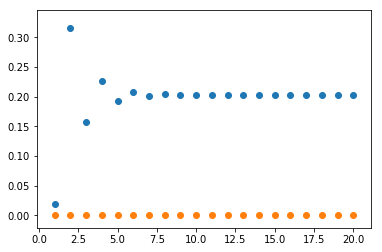

In [10]:
wb = xlrd.open_workbook("/home/pallavi/Documents/phd/Paper implementation/crowdsourcing/src/Qj.xlsx") 
sheet = wb.sheet_by_index(0) 
print (sheet.nrows)

plt.scatter(np.arange(1, sheet.nrows+1, 1), sheet.col_values(0))
plt.scatter(np.arange(1, sheet.nrows+1, 1), sheet.col_values(1))

#for i in range(sheet.nrows): 
#    print(sheet.cell_value(i, 0)) 

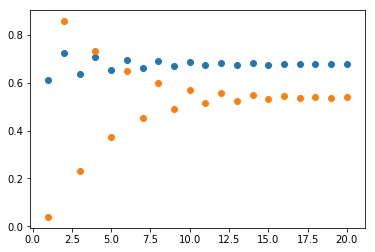

In [11]:
plt.scatter(np.arange(1, sheet.nrows+1, 1), sheet.col_values(2))
plt.scatter(np.arange(1, sheet.nrows+1, 1), sheet.col_values(3))


## Calculate accuracy of estimated labels with the help of gold data (ground truth)

In [14]:
success = 0
approx_zi_posterior = np.around(zi_posterior_probability)
for (label,i) in zip(gold_data['Label'],range(len(gold_data['Sample']))):
    #print (label)
    if (label == "No" and approx_zi_posterior[i][0] == 1):
        success += 1
    elif (label == "Yes" and approx_zi_posterior[i][1] == 1):
        success += 1
    else:
        continue
        
total = len(gold_data['Sample'])
accuracy = success/total * 100
accuracy

66.33663366336634

## Plot of true-negative vs true-positive values of annotators.

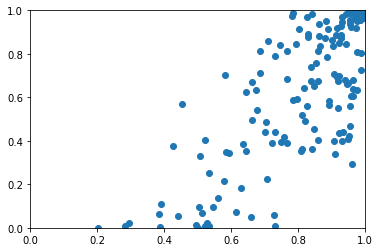

In [22]:
Qj_np = np.array(Qj)
# first variable
x = Qj_np[:,0]
# second variable
y = Qj_np[:,1]

plt.xlim(0, 1)
plt.ylim(0, 1)

# create scatter plot
plt.scatter(x, y)
# show line plot
#plt.show()